In [1]:
from dotenv import load_dotenv
load_dotenv
import os

In [2]:
from langchain.chat_models import init_chat_model

llm = init_chat_model(
    model="gpt-4.1-mini",
    temperature=0.2,
    api_key=os.getenv("OPENAI_API_KEY"),
)

In [3]:
result = llm.invoke("What is an agent?")

In [4]:
print(result)

content='An **agent** is an entity that can perceive its environment through sensors and act upon that environment through actuators or actions to achieve certain goals. Agents are commonly discussed in fields like artificial intelligence, robotics, and software systems.\n\n### In Artificial Intelligence:\n- An **intelligent agent** is a system that:\n  - **Perceives** its environment via sensors (e.g., cameras, microphones, data inputs).\n  - **Processes** the information to make decisions.\n  - **Acts** upon the environment through actuators or outputs (e.g., motors, software commands).\n  - **Autonomously** pursues goals or tasks based on its programming or learning.\n\n### Examples:\n- A **robot** that navigates a room and picks up objects.\n- A **software agent** that filters emails or recommends products.\n- A **virtual assistant** like Siri or Alexa that responds to voice commands.\n\n### Key Characteristics of Agents:\n- **Autonomy:** Operates without human intervention.\n- **R

In [5]:
from langchain.tools import tool


@tool
def write_email(
    to: str,
    subject: str,
    content: str,
) -> str:
    """write and send an email"""
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

In [6]:
type(write_email)

langchain_core.tools.structured.StructuredTool

In [7]:
write_email.args

{'to': {'title': 'To', 'type': 'string'},
 'subject': {'title': 'Subject', 'type': 'string'},
 'content': {'title': 'Content', 'type': 'string'}}

In [8]:
model_with_tool = llm.bind_tools(
    [write_email],
    tool_choice="any",
    parallel_tool_calls=False,
)
output=model_with_tool.invoke("Draft a response to my boss (boss@company.ai) about tomorrow's meeting")

In [9]:
type(output)

langchain_core.messages.ai.AIMessage

In [10]:
output

AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 67, 'total_tokens': 155, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_d0c93c37b1', 'id': 'chatcmpl-CoI0trEAC5E3E3LBvDYvh8gDClskj', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b33dc-f8ed-7631-a47d-fdcd589c9a91-0', tool_calls=[{'name': 'write_email', 'args': {'to': 'boss@company.ai', 'subject': "Re: Tomorrow's Meeting", 'content': "Dear [Boss's Name],\n\nThank you for the reminder about tomorrow's meeting. I will be prepared and ready to discuss the agenda items. Please let me know if there is anything specific you would like me to bring or focus on.\n\nBe

In [11]:
args = output.tool_calls[0]["args"]
args

{'to': 'boss@company.ai',
 'subject': "Re: Tomorrow's Meeting",
 'content': "Dear [Boss's Name],\n\nThank you for the reminder about tomorrow's meeting. I will be prepared and ready to discuss the agenda items. Please let me know if there is anything specific you would like me to bring or focus on.\n\nBest regards,\n[Your Name]"}

In [12]:
result=write_email.invoke(args)

In [13]:
result

"Email sent to boss@company.ai with subject 'Re: Tomorrow's Meeting' and content: Dear [Boss's Name],\n\nThank you for the reminder about tomorrow's meeting. I will be prepared and ready to discuss the agenda items. Please let me know if there is anything specific you would like me to bring or focus on.\n\nBest regards,\n[Your Name]"

In [14]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END


class state_schema(TypedDict):
    request: str
    email: str


workflow = StateGraph(state_schema)

In [15]:
def write_email_node(state: state_schema) -> state_schema:
    output = model_with_tool.invoke(state["request"])
    args = output.tool_calls[0]["args"]
    email = write_email.invoke(args)
    return {"email": email}

In [16]:
workflow = StateGraph(state_schema)
workflow.add_node("write_email_node", write_email_node)
workflow.add_edge(START, "write_email_node")
workflow.add_edge("write_email_node", END)

app = workflow.compile()

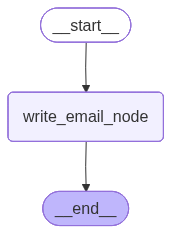

In [17]:
app

In [18]:
app.invoke(
    {
        "request": "Draft a response to my boss (boss@company.ai) about tomorrow's meeting"
    }
)

{'request': "Draft a response to my boss (boss@company.ai) about tomorrow's meeting",
 'email': "Email sent to boss@company.ai with subject 'Re: Tomorrow's Meeting' and content: Dear [Boss's Name],\n\nThank you for the reminder about tomorrow's meeting. Please let me know if there are any specific topics or materials I should prepare in advance.\n\nLooking forward to it.\n\nBest regards,\n[Your Name]"}

In [ ]:
from typing import Literal
from langgraph.graph import MessagesState
from ema